`graph.get_graph(xray=True).draw_mermaid_png()`

这个xray=True会透视显示子图

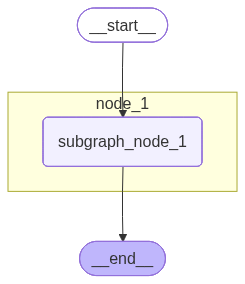

In [6]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

class SubgraphState(TypedDict):
    bar: str

# Subgraph

def subgraph_node_1(state: SubgraphState):
    return {"bar": "hi! " + state["bar"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph = subgraph_builder.compile()

# Parent graph

class State(TypedDict):
    foo: str

def call_subgraph(state: State):
    # Transform the state to the subgraph state
    subgraph_output = subgraph.invoke({"bar": state["foo"]})  
    # Transform response back to the parent state
    return {"foo": subgraph_output["bar"]}

builder = StateGraph(State)
builder.add_node("node_1", call_subgraph)
builder.add_edge(START, "node_1")
graph = builder.compile()
from IPython.display import Image
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

((), {'node_1': {'foo': 'hi! foo'}})
(('node_2:42225734-f70b-556b-2c01-a4e95f675a06',), {'subgraph_node_1': {'baz': 'baz'}})
(('node_2:42225734-f70b-556b-2c01-a4e95f675a06',), {'subgraph_node_2': {'bar': 'hi! foobaz'}})
((), {'node_2': {'foo': 'hi! foobaz'}})


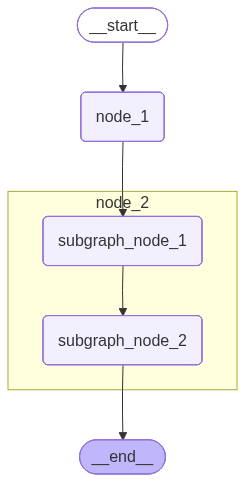

In [7]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

# Define subgraph
class SubgraphState(TypedDict):
    # note that none of these keys are shared with the parent graph state
    bar: str
    baz: str

def subgraph_node_1(state: SubgraphState):
    return {"baz": "baz"}

def subgraph_node_2(state: SubgraphState):
    return {"bar": state["bar"] + state["baz"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

# Define parent graph
class ParentState(TypedDict):
    foo: str

def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}

def node_2(state: ParentState):
    # Transform the state to the subgraph state
    response = subgraph.invoke({"bar": state["foo"]})
    # Transform response back to the parent state
    return {"foo": response["bar"]}


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

for chunk in graph.stream({"foo": "foo"}, subgraphs=True):
    print(chunk)
from IPython.display import Image
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

((), {'parent_1': {'my_key': 'hi Bob'}})
(('child:da8d2140-bc03-cb50-767d-81b668a89fe8', 'child_1:64c1a334-bf63-8053-1a18-9b891cfea2bb'), {'grandchild_1': {'my_grandchild_key': 'hi Bob, how are you'}})
(('child:da8d2140-bc03-cb50-767d-81b668a89fe8',), {'child_1': {'my_child_key': 'hi Bob, how are you today?'}})
((), {'child': {'my_key': 'hi Bob, how are you today?'}})
((), {'parent_2': {'my_key': 'hi Bob, how are you today? bye!'}})


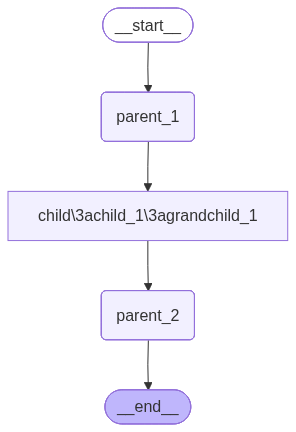

In [13]:
# Grandchild graph
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START, END

class GrandChildState(TypedDict):
    my_grandchild_key: str

def grandchild_1(state: GrandChildState) -> GrandChildState:
    # NOTE: child or parent keys will not be accessible here
    return {"my_grandchild_key": state["my_grandchild_key"] + ", how are you"}


grandchild = StateGraph(GrandChildState)
grandchild.add_node("grandchild_1", grandchild_1)

grandchild.add_edge(START, "grandchild_1")
grandchild.add_edge("grandchild_1", END)

grandchild_graph = grandchild.compile()

# Child graph
class ChildState(TypedDict):
    my_child_key: str

def call_grandchild_graph(state: ChildState) -> ChildState:
    # NOTE: parent or grandchild keys won't be accessible here
    grandchild_graph_input = {"my_grandchild_key": state["my_child_key"]}
    grandchild_graph_output = grandchild_graph.invoke(grandchild_graph_input)
    return {"my_child_key": grandchild_graph_output["my_grandchild_key"] + " today?"}

child = StateGraph(ChildState)
# We're passing a function here instead of just compiled graph (`grandchild_graph`)
child.add_node("child_1", call_grandchild_graph)
child.add_edge(START, "child_1")
child.add_edge("child_1", END)
child_graph = child.compile()

# Parent graph
class ParentState(TypedDict):
    my_key: str

def parent_1(state: ParentState) -> ParentState:
    # NOTE: child or grandchild keys won't be accessible here
    return {"my_key": "hi " + state["my_key"]}

def parent_2(state: ParentState) -> ParentState:
    return {"my_key": state["my_key"] + " bye!"}

def call_child_graph(state: ParentState) -> ParentState:
    child_graph_input = {"my_child_key": state["my_key"]}
    child_graph_output = child_graph.invoke(child_graph_input)
    return {"my_key": child_graph_output["my_child_key"]}

parent = StateGraph(ParentState)
parent.add_node("parent_1", parent_1)
# We're passing a function here instead of just a compiled graph (`child_graph`)
parent.add_node("child", call_child_graph)
parent.add_node("parent_2", parent_2)

parent.add_edge(START, "parent_1")
parent.add_edge("parent_1", "child")
parent.add_edge("child", "parent_2")
parent.add_edge("parent_2", END)

parent_graph = parent.compile()

for chunk in parent_graph.stream({"my_key": "Bob"}, subgraphs=True):
    print(chunk)
from IPython.display import Image
display(Image(parent_graph.get_graph(xray=True).draw_mermaid_png()))

# \3a是冒号:的转义，这种嵌套过多的难以正确显示